# Google colab Setup

In [1]:
!pip install catboost

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/Car_Pricing_DataSets/'   


     |████████████████████████████████| 64.7MB 46kB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Libs & DataSets uploads

In [1]:
import pandas as pd
import pandas_profiling
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re
import ast # convert string to dict

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Audio, display
sound = 'https://freesound.org/data/previews/29/29589_215874-lq.mp3'
def allDone():
    display(Audio(url=sound, autoplay=True))

file_path = '/Users/alexander/Documents/DataFactory/Projects/Car_Pricing_DataSets/'
random_state = 42

### Train set upload and NaN cleanup

In [0]:
train_set.dropna(subset=[
    'bodyType', 'modelDate', 'name', 'numberOfDoors', 'vehicleConfiguration',
    'engineDisplacement', 'enginePower','Привод'
], axis=0, inplace = True)

train_set['Владельцы'].fillna(2, inplace = True)
train_set['ПТС'].fillna('ORIGINAL', inplace = True)
train_set['description'].fillna('no_info', inplace = True)
train_set['Владение'].fillna('no_info', inplace = True)

### train_set & test_set merge

In [0]:
test_set = pd.read_csv(file_path + 'test.csv')

train_set['sample'] = 1  # mark the train set
test_set['sample'] = 0  # mark the test set
test_set['Price'] = 0  # define the absent field for the test set as well

df = train_set.append(test_set, sort=False).reset_index(drop=True)

NameError: name 'train_set' is not defined

In [0]:
# as the data featuring process takes time due to a high volume of data, a result of previous
# processing was saved and be uploaded

df = pd.read_csv(file_path + 'car_df_14_05_20.csv')

# Test set analysis

In [0]:
train_set.columns

Index(['Unnamed: 0', 'bodyType', 'brand', 'color', 'fuelType', 'modelDate',
       'name', 'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'engineDisplacement', 'enginePower', 'description', 'mileage',
       'Комплектация', 'Привод', 'Руль', 'Владельцы', 'ПТС', 'Таможня',
       'Владение', 'Price', 'sample'],
      dtype='object')

 MERCEDES      15070
VOLKSWAGEN    14753
BMW           14390
NISSAN        13699
TOYOTA        11901
AUDI           8953
MITSUBISHI     7849
SKODA          7473
VOLVO          4050
HONDA          3578
LEXUS          2782
INFINITI       2540
SUZUKI         2041
Name: brand, dtype: int64


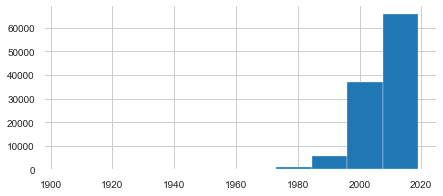

In [0]:
print('',train_set.brand.value_counts())
train_set.modelDate.hist(figsize = (7,3))

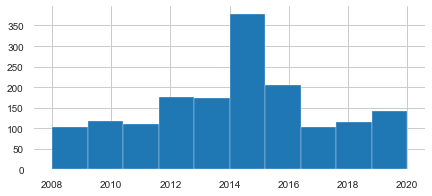

In [0]:
train_set.query(
    'name == "35i 3.0 AT (306 л.с.) 4WD" or name =="30d 3.0d AT (249 л.с.) 4WD" or name == "520i 2.0 AT (184 л.с.)"'
)['productionDate'].hist(figsize = (7,3))

In [0]:
train_set.engineDisplacement.value_counts(normalize = True)

1.6      0.130511
2.0      0.125964
1.8      0.073681
1.4      0.043207
2.5      0.042868
           ...   
M340i    0.000009
Axio     0.000009
Solio    0.000009
i        0.000009
5.3      0.000009
Name: engineDisplacement, Length: 431, dtype: float64

# Features design

In [0]:
df.Владение.fillna('no_info', inplace = True)

def period(data):
    if data == "no_info":
        return -1
    elif "{" in data:
        data = dict(ast.literal_eval(data))
        data = data['month'] + (2020 - data['year'])*12
        return data
    else: 
        data = data.split(' ')
        if "лет" or 'год' in data:
            try:
                return int(data[0])*12 + int(data[3])
            except: 
                return int(data[0])*12
            
df['ownership_period'] = df.Владение.apply(period)

del df['Владение']

In [0]:
del df['Таможня']
del df['Unnamed: 0']
del df['vehicleTransmission']


fuels = {
    "бензин": 1,
    "дизель": 2,
    "гибрид": 3,
    "электро": 4,
    "газ": 5,
    "внедорожник": 6}

df.fuelType = df.fuelType.map(fuels)

"country of origin": Japan = 0 , Germany = 1 , Czech = 2 , Sweden = 3<br>
"EU-JPN": EU = 0, JPN = 1

In [0]:
country = {
    "MERCEDES": 1,
    "VOLKSWAGEN": 1,
    "BMW": 1,
    "NISSAN": 0,
    "TOYOTA": 0,
    "AUDI": 1,
    "MITSUBISHI": 0,
    "SKODA": 2,
    "VOLVO": 3,
    "HONDA": 0,
    "LEXUS": 0,
    "INFINITI": 0,
    "SUZUKI": 0
}

df['country'] = df.brand.map(country)
df['EU-JPN'] = (df['country'] == 0).astype('int32')

In [0]:
# extract "doors" feature and "bodytype"
def doors(bodyType):
    if '2 дв' in bodyType:
        return 2
    elif '3 дв' in bodyType:
        return 3    
    elif '5 дв' in bodyType:
        return 5
    else: 
        return "-1"    
df['doors'] = df['bodyType'].apply(doors)
df['doors'] = df['doors'].astype('int32')

df['body'] = df['bodyType'].apply(lambda x: x.lower().split(' ')[0])
le = LabelEncoder()
le.fit(df.body)
df.body = le.transform(df.body)

del df['bodyType']

In [0]:
le = LabelEncoder()
le.fit(df.brand)
df.brand = le.transform(df.brand)

In [0]:
colors = {
    '040001':'чёрный',
    'FAFBFB':'белый',
    'CACECB':'серебристый',
    '97948F':'серый',
    '0000CC':'синий',
    '200204':'коричневый',
    'EE1D19':'красный',
    '007F00':'зелёный',
    'C49648':'бежевый',
    '22A0F8':'голубой',
    '660099':'пурпурный',
    'DEA522':'золотистый',
    '4A2197':'фиолетовый',
    'FFD600':'жёлтый',
    'FF8649':'оранжевый',
    'FFC0CB':'розовый',
    'чёрный':'чёрный',
    'белый':'белый',
    'синий':'синий',
    'серый':'серый',
    'коричневый':'коричневый',
    'серебристый':'серебристый',
    'красный':'красный',
    'бежевый':'бежевый',
    'голубой':'голубой',
    'зелёный':'зелёный',
    'оранжевый':'оранжевый',
    'золотистый':'золотистый',
    'пурпурный':'пурпурный',
    'фиолетовый':'фиолетовый',
    'жёлтый':'жёлтый'
    }

df.color = df.color.map(colors)

le = LabelEncoder()
le.fit(df.color)
df.color = le.transform(df.color)

In [0]:
# "hourse_power" feature
def hp(name):
    try:
        return int(name.split('(')[1].split(' ')[0])
    except: 
        return '-1'

df['hp'] = df.name.apply(hp)

In [0]:
# "four_weel_driver" feature
def four_wd(name):
    if '4wd' in name.lower():
        return 1
    else: return 0

df['four_wd'] = df.name.apply(four_wd)

In [0]:
df['drive'] = None
df['volume'] = None

for i in range(len(df)):
    try:
        engine = re.search(r'\d\.\d\D', df.name[i]).group(0)
        if 'd' in engine:
            df.drive[i] = 1
        else:
            df.drive[i] = 0
        df.volume[i] = engine[:-1]
    except: 
        df.drive[i] = -1
        df.volume[i] = -1
        
df.drive = df.drive.astype('int32')
df.volume = df.volume.astype('float')

In [0]:
#transmition type
df['transmition'] = 'no_info'

for i in range (len(df.name)):
        df['transmition'][i] = df.name[i].split('(')[0].split(' ')[-2]

le = LabelEncoder()
le.fit(df['transmition'])
df['transmition'] = le.transform(df['transmition'])

In [0]:
#BWM model
df['BMW_type'] = "no_data"
for i in range(len(df)):
    if df['brand'][i] == 'BMW':
        df['BMW_type'][i] = df['name'][i].split(' ')[0]
    else:
        df['BMW_type'][i] = "no_data"
        
#BWM class
df['BMW_class'] = 'no_data'
for i in range(len(df)):
    try:
        df['BMW_class'][i] = re.search(r'\d\d\d', df['BMW_type'][i]).group(0)[0]
    except:
        pass
    
le.fit(df['BMW_type'])
df['BMW_type'] = le.transform(df['BMW_type'])

le.fit(df['BMW_class'])
df['BMW_class'] = le.transform(df['BMW_class'])

del df['name']

In [0]:
#feature age
current_year = 2020
df['age'] = 0 

for i in range(len(df)):
    df['age'][i] = 2020 - df['productionDate'][i]

признак hyb

In [0]:
for i in range(len(df)):
    if 'MECHANICAL' in df.vehicleConfiguration[i]:
        df.vehicleConfiguration[i] = 0
    elif 'AUTOMATIC' in df.vehicleConfiguration[i]:
        df.vehicleConfiguration[i] = 1
    elif 'VARIATOR' in df.vehicleConfiguration[i]:
        df.vehicleConfiguration[i] = 2
    elif 'ROBOT' in df.vehicleConfiguration[i]:
        df.vehicleConfiguration[i] = 3
    else: 
        df.vehicleConfiguration[i] = -1
        
df.vehicleConfiguration = df.vehicleConfiguration.astype('int64')

In [0]:
# engine_type
# ?probably to be revised
#  letter to be found: h, hyb, LTR, i, e, si, xi, is, L, Li, Ld, other

for i in range(len(df)):
    if 'h' in df['engineDisplacement'][i]:
        df['engineDisplacement'][i] = 1
    elif 'LTR' in df['engineDisplacement'][i]:
        df['engineDisplacement'][i] = 2
    elif 'si' in df['engineDisplacement'][i]:
        df['engineDisplacement'][i] = 3
    elif 'xi' in df['engineDisplacement'][i]:
        df['engineDisplacement'][i] = 4
    elif 'is' in df['engineDisplacement'][i]:
        df['engineDisplacement'][i] = 5    
    elif 'Li' in df['engineDisplacement'][i]:
        df['engineDisplacement'][i] = 6
    elif 'Ld' in df['engineDisplacement'][i]:
        df['engineDisplacement'][i] = 7
    else:
        df['engineDisplacement'][i] = -1

df.engineDisplacement = df.engineDisplacement.astype('int64')

In [0]:
# engine_power
df['n_type'] = 0
for i in range(len(df)):
    if "N" in str(df.enginePower[i]):
        df.enginePower[i] = df.enginePower[i].split(' ')[0]
        df.n_type[i] = 1
    else: 
        pass
    
df.enginePower = df.enginePower.astype('int32')

In [0]:
df.Привод = df.Привод.map({'полный': 0, 'передний': 1, 'задний':2})

df.Руль = df.Руль.map({'LEFT': 0, 'Левый': 0, 'RIGHT':1})

df.ПТС = df.ПТС.map({'ORIGINAL': 0, 'DUPLICATE': 1, 'Оригинал':0, 'Дубликат':1 })

df.Состояние = (df['Состояние'] == 'Не требует ремонта').astype('int32')

# qnnty of owners:
def owners(x):
    x = str(x)
    if  re.search(r'\d\s\w+', x) == None:
        return int(x[0])
    else:
        return int(x.split('в')[0][0])

df.Владельцы.fillna('3', inplace = True)
df.Владельцы = df.Владельцы.apply(owners)

сделать отдельный признак "те кто без описания"

In [0]:
# car features description

features = [
    'AUX', 'Android Auto', 'Bluetooth', 'CarPlay', 'USB',
    'Автоматический корректор фар', 'Адаптивный круиз-контроль',
    'Активная подвеска', 'Активный усилитель руля',
    'Алькантара (Материал салона)', 'Антиблокировочная система (ABS)',
    'Антипробуксовочная система (ASR)', 'Аудиоподготовка', 'Аудиосистема',
    'Аудиосистема Hi-Fi', 'Аудиосистема с TV', 'Аэрография',
    'Беспроводная зарядка для смартфона', 'Блокировка замков задних дверей',
    'Бортовой компьютер', 'Бронированный кузов', 'Велюр (Материал салона)',
    'Вентиляция задних сидений', 'Вентиляция передних сидений',
    'Газобаллонное оборудование', 'Голосовое управление',
    'Датчик давления в шинах', 'Датчик дождя',
    'Датчик проникновения в салон (датчик объема)', 'Датчик света',
    'Датчик усталости водителя', 'Декоративная подсветка салона',
    'Декоративные молдинги', 'Декоративные накладки на педали', 'Диски 14',
    'Диски 15', 'Диски 16', 'Диски 17', 'Диски 18', 'Диски 19', 'Диски 20',
    'Диски 21', 'Диски 22', 'Дистанционный запуск двигателя',
    'Дневные ходовые огни', 'Доводчик дверей', 'Докатка',
    'Запуск двигателя с кнопки', 'Защита картера', 'Иммобилайзер',
    'Искусственная кожа (Материал салона)', 'Камера 360°', 'Камера задняя',
    'Камера передняя', 'Климат-контроль 1-зонный', 'Климат-контроль 2-зонный',
    'Климат-контроль многозонный', 'Кожа (Материал салона)',
    'Количество мест: 2', 'Количество мест: 4', 'Количество мест: 5',
    'Количество мест: 6', 'Количество мест: 7',
    'Комбинированный (Материал салона)', 'Кондиционер',
    'Крепление детского кресла (задний ряд) ISOFIX',
    'Крепление детского кресла (передний ряд) ISOFIX', 'Круиз-контроль',
    'Ксеноновые/Биксеноновые фары', 'Лазерные фары',
    'Ламинированные боковые стекла', 'Легкосплавные диски', 'Люк', 'Металлик',
    'Мультимедиа система для задних пассажиров',
    'Мультифункциональное рулевое колесо', 'Навигационная система',
    'Накладки на пороги', 'Обвес кузова', 'Обогрев рулевого колеса',
    'Омыватель фар', 'Отделка кожей рулевого колеса',
    'Отделка кожей рычага КПП', 'Отделка потолка чёрной тканью',
    'Открытие багажника без помощи рук', 'Охлаждаемый перчаточный ящик',
    'Память передних сидений', 'Память сиденья водителя',
    'Панорамная крыша / лобовое стекло', 'Парктроник задний',
    'Парктроник передний', 'Передний центральный подлокотник',
    'Пневмоподвеска', 'Подогрев задних сидений', 'Подогрев передних сидений',
    'Подрулевые лепестки переключения передач',
    'Подушка безопасности водителя',
    'Подушка безопасности для защиты коленей водителя',
    'Подушка безопасности пассажира', 'Подушки безопасности боковые',
    'Подушки безопасности боковые задние',
    'Подушки безопасности оконные (шторки)', 'Полноразмерное запасное колесо',
    'Прикуриватель и пепельница', 'Программируемый предпусковой отопитель',
    'Проекционный дисплей', 'Противотуманные фары',
    'Регулировка передних сидений по высоте', 'Регулировка руля по вылету',
    'Регулировка руля по высоте', 'Регулировка сиденья водителя по высоте',
    'Регулируемый педальный узел', 'Рейлинги на крыше', 'Розетка 12V',
    'Розетка 220V', 'Рулевая колонка с памятью положения', 'Светлый салон',
    'Светодиодные фары', 'Сигнализация', 'Сигнализация с обратной связью',
    'Сиденья с массажем', 'Система «старт-стоп»',
    'Система автоматической парковки', 'Система адаптивного освещения',
    'Система выбора режима движения', 'Система доступа без ключа',
    'Система контроля за полосой движения', 'Система контроля слепых зон',
    'Система ночного видения', 'Система помощи при спуске',
    'Система помощи при старте в гору (HSA)',
    'Система помощи при торможении (BAS, EBD)',
    'Система предотвращения столкновения',
    'Система распознавания дорожных знаков', 'Система стабилизации (ESP)',
    'Система стабилизации рулевого управления (VSM)',
    'Система управления дальним светом',
    'Складной столик на спинках передних сидений',
    'Складывающееся заднее сиденье', 'Солнцезащитная шторка на заднем стекле',
    'Солнцезащитные шторки в задних дверях', 'Спортивная подвеска',
    'Спортивные передние сиденья', 'Стальные диски', 'Ткань (Материал салона)',
    'Тонированные стекла', 'Третий задний подголовник', 'Третий ряд сидений',
    'Тёмный салон', 'Усилитель руля', 'Фаркоп',
    'Функция складывания спинки сиденья пассажира', 'Центральный замок',
    'ЭРА-ГЛОНАСС', 'Электронная приборная панель',
    'Электрообогрев боковых зеркал', 'Электрообогрев зоны стеклоочистителей',
    'Электрообогрев лобового стекла',
    'Электрообогрев форсунок стеклоомывателей', 'Электропривод зеркал',
    'Электропривод крышки багажника', 'Электрорегулировка задних сидений',
    'Электрорегулировка передних сидений', 'Электрорегулировка руля',
    'Электрорегулировка сиденья водителя', 'Электроскладывание зеркал',
    'Электростеклоподъёмники задние', 'Электростеклоподъёмники передние',
    'Яндекс.Авто'
]

def find_item(features, item):
    features.find(item)
    if features.find(item) > 0:
        return 1
    else: 
        return 0

for item in features:
    df[item] = df['Комплектация'].apply(find_item, item = item)

del df['Комплектация']

In [0]:
#df.to_csv('DataSets/car_df.csv', index = False)

#  Modeling

In [2]:
df = pd.read_csv(file_path + 'car_df_14_05_20.csv')

X = df.query('sample == 1').drop(['sample', 'Price', 'description'], axis=1)
y = df.query('sample == 1')['Price']

kaggle_X = df.query('sample == 0').drop(['sample', 'Price', 'description'], axis=1)

In [3]:
#MAPE function

def MAPE(y_true, y_pred):
  y_pred = round(y_pred,0) 
  return np.mean(np.abs((y_true - y_pred)/y_true))*100

## XGBoost

### XGBoost baseline

In [0]:
%%time
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

X = df.query('sample == 1').drop(['sample', 'Price', 'description'], axis=1)
y = df.query('sample == 1')['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_state)

xgb_model = xgb.XGBRegressor(objective ='reg:linear',
                                learning_rate = 0.1,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 200,
                                min_child_weight = 1,
                                gamma = 0,
                                subsample = 0.8,
                                colsample_bytree=0.8,
                                scale_pos_weight = 1, 
                                seed = random_state,
                                
                                nthread=-1,
                                silent=1)

xgb_model.fit(X_train,y_train)
y_pred = xgb_model.predict(X_test)

print("MAPE: ", MAPE(y_test, y_pred))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred)))

allDone()

MAPE:  17.1667218208313
RMSE:  435703.0268621042


CPU times: user 4min 34s, sys: 1.85 s, total: 4min 35s
Wall time: 1min 17s


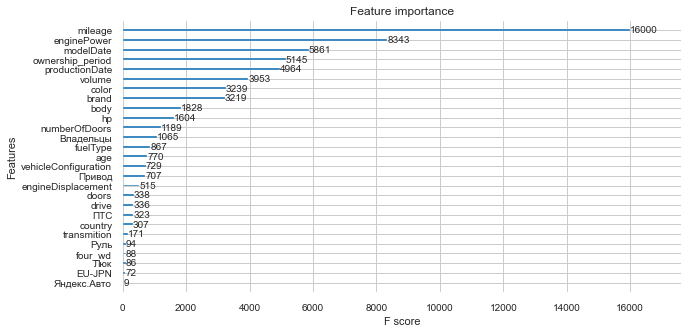

In [0]:
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

### XGBoost improvement

#### n_estimators tuning

In [0]:
%%time
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

X = df.query('sample == 1').drop(['sample', 'Price', 'description'], axis=1)
y = df.query('sample == 1')['Price']

random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_state)

def xgb_model_train(n_estimators):
    xgb_model = xgb.XGBRegressor(objective ='reg:linear',
                                    learning_rate = 0.1,
                                    max_depth = 5,
                                    alpha = 10,
                                    n_estimators = n_estimators,
                                    min_child_weight = 1,
                                    gamma = 0,
                                    subsample = 0.8,
                                    colsample_bytree=0.8,
                                    scale_pos_weight = 1, 
                                    seed = random_state,

                                    nthread=-1,
                                    silent=1)
    xgb_model.fit(X_train,y_train)
    y_pred = xgb_model.predict(X_test)
    print("n_estimators: ", n_estimators)
    print("MAPE: ", MAPE(y_test, y_pred))
    print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred)))   
    return

for n_estimators in range(300, 3500, 500):
    xgb_model_train(n_estimators)
    
allDone()

n_estimators:  300
MAPE:  16.44345074892044
RMSE:  428082.7112405894
n_estimators:  800
MAPE:  14.795021712779999
RMSE:  414679.17449447763
n_estimators:  1300
MAPE:  14.273104071617126
RMSE:  411482.4858066879
n_estimators:  1800
MAPE:  13.993574678897858
RMSE:  410308.8011349818
n_estimators:  2300
MAPE:  13.819056749343872
RMSE:  410519.3004646956
n_estimators:  2800
MAPE:  13.713741302490234
RMSE:  409187.5599454386
n_estimators:  3300
MAPE:  13.60560953617096
RMSE:  411152.85589997744


CPU times: user 4h 45min 5s, sys: 44.6 s, total: 4h 45min 49s
Wall time: 1h 17min 6s


#### max_depth & min_child_weight tuning

In [0]:
%%time
param_test2 = {'max_depth':range(3,10,2),
               'min_child_weight':range(1,6,2)}

gsearch2 = GridSearchCV(estimator = xgb.XGBRegressor(objective ='reg:linear',
                                learning_rate = 0.1,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 2300,
                                min_child_weight = 1,
                                gamma = 0,
                                subsample = 0.8,
                                colsample_bytree=0.8,
                                scale_pos_weight = 1, 
                                seed = random_state,
                                
                                nthread=4,
                                silent=1),
                        param_grid = param_test2,
                        scoring='neg_root_mean_squared_error')

gsearch2.fit(X_train,y_train)

print('RMSE: ', -max(gsearch2.cv_results_['mean_test_score']))
index = gsearch2.cv_results_['mean_test_score'].tolist().index(max(gsearch2.cv_results_['mean_test_score']))
print('params: ', gsearch2.cv_results_['params'][index])
pd.Series(gsearch2.cv_results_['mean_test_score']).plot()

allDone()

best option is: max_depth = 5 & min_child_weight = 1<br>

#### gamma tuning (Failed)

[22:09:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:21:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:33:02] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:44:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:09:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:20:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:31:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:44:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

CPU times: user 18h 2min 3s, sys: 4min 15s, total: 18h 6min 18s
Wall time: 5h 10min 17s


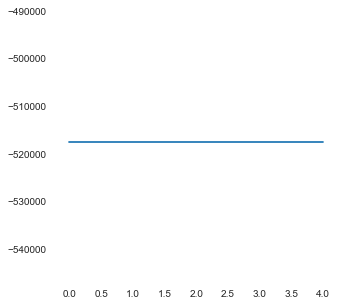

In [0]:
%%time
from sklearn.model_selection import GridSearchCV

param_test3 = {'gamma':[i/10.0 for i in range(0,5)]}

gsearch3 = GridSearchCV(estimator = xgb.XGBRegressor(objective ='reg:linear',
                                learning_rate = 0.1,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 2300,
                                min_child_weight = 1,
                                gamma = 0,
                                subsample = 0.8,
                                colsample_bytree=0.8,
                                scale_pos_weight = 1, 
                                seed = random_state,
                                
                                nthread=4,
                                silent=0),
                        param_grid = param_test3,
                        scoring='neg_root_mean_squared_error')

gsearch3.fit(X_train,y_train)

print('RMSE: ', -max(gsearch3.cv_results_['mean_test_score']))
index = gsearch3.cv_results_['mean_test_score'].tolist().index(max(gsearch3.cv_results_['mean_test_score']))
print('params: ', gsearch3.cv_results_['params'][index])
pd.Series(gsearch3.cv_results_['mean_test_score']).plot()

allDone()

#### subsample & colsample_bytree tuning

RMSE:  523230.56172694033
params:  {'colsample_bytree': 0.92, 'subsample': 0.98}


CPU times: user 5h 26min 44s, sys: 1min 31s, total: 5h 28min 16s
Wall time: 1h 36min 30s


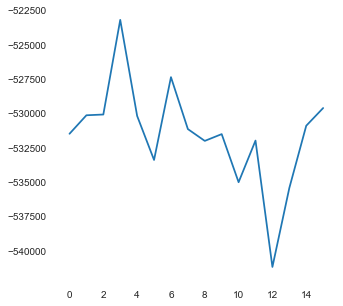

In [0]:
%%time
param_test4 = {
 'subsample':[0.92, 0.94, 0.96, 0.98],
 'colsample_bytree':[0.92, 0.94, 0.96, 0.98]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(objective ='reg:linear',
                                learning_rate = 0.1,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 200,
                                min_child_weight = 1,
                                gamma = 0,
                                subsample = 0.8,
                                colsample_bytree=0.8,
                                scale_pos_weight = 1, 
                                seed = random_state,
                                
                                nthread=4,
                                silent=1),
                        param_grid = param_test4,
                        scoring='neg_root_mean_squared_error')

gsearch4.fit(X_train,y_train)

print('RMSE: ', -max(gsearch4.cv_results_['mean_test_score']))
index = gsearch4.cv_results_['mean_test_score'].tolist().index(max(gsearch4.cv_results_['mean_test_score']))
print('params: ', gsearch4.cv_results_['params'][index])
pd.Series(gsearch4.cv_results_['mean_test_score']).plot()

allDone()

RMSE:  521939.68754435953
params:  {'colsample_bytree': 0.94, 'subsample': 0.99}
CPU times: user 2h 3min 5s, sys: 32.2 s, total: 2h 3min 37s
Wall time: 34min 36s


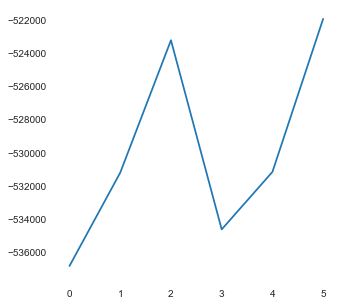

In [0]:
%%time
param_test4 = {
 'subsample':[0.98, 0.99],
 'colsample_bytree':[0.91, 0.92, 0.94]
}

gsearch4 = GridSearchCV(estimator = xgb.XGBRegressor(objective ='reg:linear',
                                learning_rate = 0.1,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 200,
                                min_child_weight = 1,
                                gamma = 0,
                                subsample = 0.8,
                                colsample_bytree=0.8,
                                scale_pos_weight = 1, 
                                seed = random_state,
                                
                                nthread=4,
                                silent=1),
                        param_grid = param_test4,
                        scoring='neg_root_mean_squared_error')

gsearch4.fit(X_train,y_train)

print('RMSE: ', -max(gsearch4.cv_results_['mean_test_score']))
index = gsearch4.cv_results_['mean_test_score'].tolist().index(max(gsearch4.cv_results_['mean_test_score']))
print('params: ', gsearch4.cv_results_['params'][index])
pd.Series(gsearch4.cv_results_['mean_test_score']).plot()

#### Step 5: Tuning Regularization Parameters

RMSE:  504690.8928702511
params:  {'colsample_bytree': 0.94, 'subsample': 0.99}
CPU times: user 23h 17min 33s, sys: 6min 5s, total: 23h 23min 38s
Wall time: 6h 58min 29s


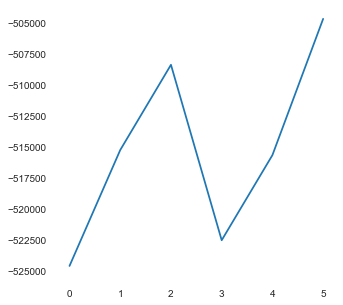

In [0]:
%%time
param_test5 = {
 'subsample':[0.98, 0.99],
 'colsample_bytree':[0.91, 0.92, 0.94]
}

gsearch5 = GridSearchCV(estimator = xgb.XGBRegressor(objective ='reg:linear',
                                learning_rate = 0.1,
                                max_depth = 5,
                                alpha = 10,
                                n_estimators = 2300,
                                min_child_weight = 1,
                                gamma = 0,
                                subsample = 0.99,
                                colsample_bytree=0.94,
                                scale_pos_weight = 1, 
                                seed = random_state,
                                
                                nthread=4,
                                silent=1),
                        param_grid = param_test5,
                        scoring='neg_root_mean_squared_error')

gsearch5.fit(X_train,y_train)

print('RMSE: ', -max(gsearch5.cv_results_['mean_test_score']))
index = gsearch5.cv_results_['mean_test_score'].tolist().index(max(gsearch5.cv_results_['mean_test_score']))
print('params: ', gsearch5.cv_results_['params'][index])
pd.Series(gsearch5.cv_results_['mean_test_score']).plot()

#### learning_rate tuning

learning_rate 0.01, 0.05, 0.09 didn't bring an MAPE improvement so keep  learning_rate = 0.1

### XGB_model folding

#### "best parametrs" model (MAPE = 12.203)

In [60]:
%%time
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

xgb_model = xgb.XGBRegressor(objective ='reg:linear',
                                    learning_rate = 0.1,
                                    max_depth = 5,
                                    alpha = 10,
                                    n_estimators = 3300,
                                    # n_estimators = 3,
                                    
                                    min_child_weight = 1,
                                    gamma = 0,
                                    subsample = 0.98,
                                    colsample_bytree=0.92,
                                    scale_pos_weight = 1, 
                                    seed = random_state,
                                    
                                    tree_method='gpu_hist',
                                    gpu_id=0, 
                                 
                                    nthread=-1,
                                    silent=1)

CPU times: user 11.2 ms, sys: 3.27 ms, total: 14.5 ms
Wall time: 116 ms


In [20]:
%%time
random_state = random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_state)

#model = xgb(X_train,y_train)
xgb = xgb_model.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
print("MAPE: ", MAPE(y_test, y_pred))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred)))   

allDone()

MAPE:  13.477402925491333
RMSE:  429024.26919093734


CPU times: user 18.3 s, sys: 10.2 s, total: 28.5 s
Wall time: 28.5 s


#### xgb_folding

In [0]:
def xgb_folding(N_FOLDS, xgb_model, X, y, df_models_result, kaggle_X, df_kaggle, silent = False):
    # N_FOLDS - folds quantity
    # xgb_model - xgb model params
    # X, y - train dataset
    # df_models_result - df to collect 'y'
    # kaggle_X - kaggle data to submit
    # df_kaggle - df to collent Kaggle data for submition
    # silent - if True, tthe function prints intermediate results for each fold
    
    score_ls = []
    splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state).split(X, y))

    for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS):

        # use the indexes to extract the folds in the train and validation data
        X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]

        # model for this fold
        xgb = xgb_model.fit(X_train,y_train)

        # score model on test
        test_predict = xgb.predict(X_test)
        test_score = MAPE(y_test, test_predict)
        score_ls.append(test_score)
        print(f"{idx+1} Fold Test MAPE: {MAPE(y_test, test_predict):0.3f}")

        df_models_result[f'xgb_{idx+1}'] = xgb.predict(X)
        #model.save_model(f'catboost_fold_{idx+1}.model')
        
        if silent == False:
            print(f'Mean Score: {np.mean(score_ls):0.3f}')
            print(f'Std Score: {np.std(score_ls):0.4f}')
            print(f'Max Score: {np.max(score_ls):0.3f}')
            print(f'Min Score: {np.min(score_ls):0.3f}')
        
        df_kaggle[f'kaggle_xgb_{idx+1}'] = xgb.predict(kaggle_X)
    
    return df_models_result, df_kaggle  

## CatBoost

### CatBoost BaseModel

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_state)

# CATBOOST Params
ITERATIONS = 2000
LR         = 0.1

model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = random_state,
                          eval_metric='MAPE',
                          custom_metric=[
                                        #  'R2',
                                         'MAE'],
                          l2_leaf_reg = 3, #l2 regularisation. To be increased if overfitting   (3 - default)
#                           baggin_temperature = 1,
#                           task_type="GPU",
#                           devices='0:1'
                          ) 
model.fit(X_train, y_train,
         #cat_features=cat_features,
         eval_set=(X_test, y_test),
         verbose_eval=2000,
        #  logging_level = 'Info',
         use_best_model=True,
          early_stopping_rounds = 1000,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.2899779	test: 1.3119886	best: 1.3119886 (0)	total: 20.4ms	remaining: 40.8s
1999:	learn: 0.1280630	test: 0.1408905	best: 0.1408905 (1999)	total: 25.2s	remaining: 0us

bestTest = 0.1408905009
bestIteration = 1999



In [0]:
# from sklearn.model_selection import GridSearchCV

# parameters = {'learning_rate': [1, 0.5, 0.05],
#         'depth': [4, 6, 10],
#         'iterations': [20000, 30000],
#         'l2_leaf_reg': [1, 3, 5, 7, 9, 11]}

# grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1, verbose =1)
# grid.fit(X_train, y_train) 

# print("\n========================================================")
# print(" Results from Grid Search " )
# print("========================================================")    
    
# print("\n The best estimator across ALL searched params:\n",
#           grid.best_estimator_)
    
# print("\n The best score across ALL searched params:\n",
#           grid.best_score_)
# print("\n The best parameters across ALL searched params:\n",
#           grid.best_params_)
# print("\n ========================================================")

# allDone()

Fitting 2 folds for each of 108 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
grid = {'learning_rate': [1, 0.5, 0.05],
        'depth': [4, 6, 10],
        'iterations': [20000, 30000],
        'l2_leaf_reg': [1, 3, 5, 7, 9, 11]}

grid_search_result = model.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train,
                                       verbose = 1000,
                                       plot=True)
allDone()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.1560862	best: 0.1560862 (0)	total: 2m 27s	remaining: 4h 22m 19s


In [0]:
cat_features = ['brand',
 'color',
 'fuelType',
#  'numberOfDoors',
 'vehicleConfiguration',
 'engineDisplacement',
 'Привод',
 'Руль',
 'ПТС',
 'country',
 'EU-JPN',
 'doors',
 'body',
 'four_wd',
 'drive',
 'transmition',
 'n_type'
]

df['numberOfDoors'] = df['numberOfDoors'].astype('int')

df[cat_features] = df[cat_features].astype('object')


### CatBoost Folding

In [0]:
def CatBoost_model(y_train, X_train, X_test, y_test):
    
    #ITERATIONS = 2
    ITERATIONS = 20000
    LR         = 0.1
    
    model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              random_seed = random_state,
                              eval_metric='MAPE',
                              custom_metric=['R2', 'MAE'],
                              task_type="GPU",
                              devices='0:1')
    model.fit(X_train, y_train,
             #cat_features=cat_features,
             eval_set=(X_test, y_test),
              verbose_eval=2000,
             use_best_model=True,
             #plot=True
             )
                   
    return model

In [0]:
from sklearn.model_selection import KFold
from tqdm import tqdm
    
def CatBoost_folding(N_FOLDS, X, y, df_models_result, kaggle_X, df_kaggle, silent = False):
    # N_FOLDS = folds quantity
    # X, y - train dataset
    # df_models_result - df to collect 'y'
    # kaggle_X - kaggle data to submit
    # df_kaggle - df to collent Kaggle data for submition
    # silent - if True, tthe function prints intermediate results for each fold
    
    score_ls = []
    splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state).split(X, y))

    for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS):

        # use the indexes to extract the folds in the train and validation data
        X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]

        # model for this fold
        model = CatBoost_model(y_train, X_train, X_test, y_test)

        # score model on test
        test_predict = model.predict(X_test)
        test_score = MAPE(y_test, test_predict)
        score_ls.append(test_score)
        print(f"{idx+1} Fold Test MAPE: {MAPE(y_test, test_predict):0.3f}")

        df_models_result[f'CatBoost_{idx+1}'] = model.predict(X)
        #model.save_model(f'catboost_fold_{idx+1}.model')

        if silent == False:   
            print(f'Mean Score: {np.mean(score_ls):0.3f}')
            print(f'Std Score: {np.std(score_ls):0.4f}')
            print(f'Max Score: {np.max(score_ls):0.3f}')
            print(f'Min Score: {np.min(score_ls):0.3f}')
        
        df_kaggle[f'kaggle_CatBoost_{idx+1}'] = model.predict(kaggle_X)
    
    return df_models_result, df_kaggle  

results with non-categorical features:<br>
MAPE-min:  9.185568422076066<br>
MAPE-mean:  9.013300275766742<br>
MAPE-max:  11.6359553759962<br>

## Models Stacking  

<b>Approach Description:</b><br><br>
Scenario 1: (XGBoost CV5 + CatBoost CV5) -> CatBoost<br>
Scenario 2: (XGBoost CV5 + CatBoost CV5) -> XGBoost<br>
Scenario 3: (XGBoost CV5 + CatBoost CV5 + SkLearn Regression) -> XGBoost<br>
Scenario 4: (XGBoost CV5 + CatBoost CV5 + SkLearn Regression) -> CatBoost<br><br>
Scenario 6: (XGBoost + CatBoost) -> XGBoost<br>
Scenario 7: (XGBoost + CatBoost) -> CatBoost<br>
Scenario 7: (XGBoost + CatBoost + SkLearn Regression) -> XGBoost<br>
Scenario 8: (XGBoost + CatBoost + SkLearn Regression) -> CatBoost<br><br>

#### meta_feature preparation

In [69]:
N_FOLDS = 2

# Df to record predictions for diferent models and Folds
df_models_result = pd.DataFrame(index=y.index)

# df to record predictions Kaggle data
df_kaggle = pd.DataFrame() 

print('XGB calculation...')
df_models_result, df_kaggle = xgb_folding(N_FOLDS, xgb_model, X, y, df_models_result, kaggle_X, df_kaggle, silent = True)

print('CatBoost calculation...')
df_models_result, df_kaggle = CatBoost_folding(N_FOLDS, X, y, df_models_result, kaggle_X, df_kaggle, silent = True)

allDone()





  0%|          | 0/2 [00:00<?, ?it/s]

XGB calculation...
1 Fold Test MAPE: 13.755






 50%|█████     | 1/2 [00:34<00:34, 34.92s/it]

2 Fold Test MAPE: 13.933






100%|██████████| 2/2 [01:09<00:00, 34.60s/it]




  0%|          | 0/2 [00:00<?, ?it/s]

CatBoost calculation...


Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 1.2994806	test: 1.2776735	best: 1.2776735 (0)	total: 10.8ms	remaining: 3m 36s
2000:	learn: 0.1396475	test: 0.1513415	best: 0.1513355 (1991)	total: 21.1s	remaining: 3m 9s
4000:	learn: 0.1296610	test: 0.1459225	best: 0.1459076 (3965)	total: 41.9s	remaining: 2m 47s
6000:	learn: 0.1246086	test: 0.1438879	best: 0.1438820 (5994)	total: 1m 1s	remaining: 2m 24s
8000:	learn: 0.1213573	test: 0.1424404	best: 0.1424355 (7931)	total: 1m 22s	remaining: 2m 3s
10000:	learn: 0.1188680	test: 0.1413041	best: 0.1413029 (9998)	total: 1m 41s	remaining: 1m 41s
12000:	learn: 0.1168642	test: 0.1406829	best: 0.1406768 (11977)	total: 2m 1s	remaining: 1m 21s
14000:	learn: 0.1153746	test: 0.1401917	best: 0.1401664 (13915)	total: 2m 22s	remaining: 1m
16000:	learn: 0.1141158	test: 0.1397159	best: 0.1397144 (15999)	total: 2m 42s	remaining: 40.6s
18000:	learn: 0.1130642	test: 0.1394132	best: 0.1394097 (17828)	total: 3m 2s	remaining: 20.3s
19999:	learn: 0.1121133	test: 0.1391310	best: 0.1391049 (19847)	total:





 50%|█████     | 1/2 [03:28<03:28, 208.17s/it]Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 1.2812901	test: 1.3030061	best: 1.3030061 (0)	total: 12.2ms	remaining: 4m 4s
2000:	learn: 0.1437781	test: 0.1554900	best: 0.1554791 (1993)	total: 20.5s	remaining: 3m 4s
4000:	learn: 0.1344925	test: 0.1496972	best: 0.1496732 (3963)	total: 41.5s	remaining: 2m 46s
6000:	learn: 0.1300614	test: 0.1472799	best: 0.1472799 (6000)	total: 1m 2s	remaining: 2m 26s
8000:	learn: 0.1271955	test: 0.1459917	best: 0.1459721 (7974)	total: 1m 22s	remaining: 2m 4s
10000:	learn: 0.1252180	test: 0.1451780	best: 0.1451730 (9996)	total: 1m 43s	remaining: 1m 42s
12000:	learn: 0.1236808	test: 0.1445851	best: 0.1445150 (11826)	total: 2m 3s	remaining: 1m 22s
14000:	learn: 0.1224417	test: 0.1441788	best: 0.1441777 (13997)	total: 2m 22s	remaining: 1m 1s
16000:	learn: 0.1213422	test: 0.1437665	best: 0.1437104 (15694)	total: 2m 42s	remaining: 40.7s
18000:	learn: 0.1203972	test: 0.1434655	best: 0.1434300 (17712)	total: 3m 2s	remaining: 20.3s
19999:	learn: 0.1194532	test: 0.1431796	best: 0.1431679 (19964)	tota





100%|██████████| 2/2 [06:57<00:00, 208.50s/it]


In [0]:
#result analysis:
xgb = []
for i in df_models_result.columns:
    if "xgb" in i:
        xgb.append(i)

df_models_result['xgb_min'] = df_models_result[xgb].min(axis = 1)
df_models_result['xgb_mean'] = df_models_result[xgb].mean(axis = 1)
df_models_result['xgb_max'] = df_models_result[xgb].max(axis = 1)


Cat = []
for i in df_models_result.columns:
    if "Cat" in i:
        Cat.append(i)

df_models_result['Cat_min'] = df_models_result[Cat].min(axis = 1)
df_models_result['Cat_mean'] = df_models_result[Cat].mean(axis = 1)
df_models_result['Cat_max'] = df_models_result[Cat].max(axis = 1)

df_models_result['total_min'] = df_models_result.min(axis = 1)
df_models_result['total_mean'] = df_models_result.mean(axis = 1)
df_models_result['total_max'] = df_models_result.max(axis = 1)

df_models_result.to_csv(file_path + 'df_stacking_17_05_20.csv', index = True)

In [76]:
print("MAPE_cat_mean: ", MAPE(y, df_models_result['Cat_mean']))
print("MAPE_cat_min: ", MAPE(y, df_models_result['Cat_min']))
print("MAPE_cat_max: ", MAPE(y, df_models_result['Cat_max']))
print('  ')
print("MAPE_xgb_mean: ", MAPE(y, df_models_result['xgb_mean']))
print("MAPE_xgb_min: ", MAPE(y, df_models_result['xgb_min']))
print("MAPE_xgb_max: ", MAPE(y, df_models_result['xgb_max']))
print('  ')
print("MAPE_total_mean: ", MAPE(y, df_models_result['total_mean']))
print("MAPE_total_min: ", MAPE(y, df_models_result['total_min']))
print("MAPE_total_max: ", MAPE(y, df_models_result['total_max']))

MAPE_cat_mean:  12.472279943485818
MAPE_cat_min:  11.850748267351534
MAPE_cat_max:  13.841063031020079
  
MAPE_xgb_mean:  11.801455169916153
MAPE_xgb_min:  11.051518470048904
MAPE_xgb_max:  13.272728025913239
  
MAPE_total_mean:  11.808255923405536
MAPE_total_min:  11.439915307240888
MAPE_total_max:  14.83091342921644


#### Scenario 1: (XGBoost CV5 + CatBoost CV5) -> XGBoost

In [0]:
df_models_result = pd.read_csv(file_path + 'df_stacking_17_05_20.csv')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df_models_result, y, train_size=0.8, random_state=random_state)
    
# ITERATIONS = 2
ITERATIONS = 20000
LR         = 0.1
    
model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              random_seed = random_state,
                              eval_metric='MAPE',
                              custom_metric=['R2', 'MAE'],
                              task_type="GPU",
                              devices='0:1'
                             )

model.fit(X_train, y_train,
             #cat_features=cat_features,
             eval_set=(X_test, y_test),
              verbose_eval=2000,
             use_best_model=True,
             #plot=True
             )

y_pred = model.predict(X_test)

# df_kaggle[f'kaggle_CatBoost_{idx+1}'] = model.predict(kaggle_X)
# df_kaggle['price'] = df_kaggle['price'].apply(lambda x: round(x,0))
# df_kaggle.rename_axis('id', inplace=True)


print('Scenario 1: (XGBoost CV5 + CatBoost CV5) -> CatBoost ')
print("MAPE: ", MAPE(y_test, y_pred))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred)))   

allDone()

Metric R2 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 1.2541048	test: 1.2757973	best: 1.2757973 (0)	total: 11.2ms	remaining: 3m 44s
2000:	learn: 0.1259175	test: 0.1364970	best: 0.1364837 (1959)	total: 19.1s	remaining: 2m 52s
4000:	learn: 0.1249525	test: 0.1357206	best: 0.1356961 (3873)	total: 38.4s	remaining: 2m 33s
6000:	learn: 0.1246599	test: 0.1354429	best: 0.1354248 (5834)	total: 57.7s	remaining: 2m 14s
8000:	learn: 0.1243708	test: 0.1351648	best: 0.1351608 (7976)	total: 1m 16s	remaining: 1m 54s
10000:	learn: 0.1241456	test: 0.1349964	best: 0.1349818 (9879)	total: 1m 34s	remaining: 1m 34s
12000:	learn: 0.1241240	test: 0.1349956	best: 0.1349687 (11650)	total: 1m 52s	remaining: 1m 14s
14000:	learn: 0.1240380	test: 0.1348519	best: 0.1348482 (13875)	total: 2m 10s	remaining: 56s
16000:	learn: 0.1239690	test: 0.1347687	best: 0.1347615 (15462)	total: 2m 29s	remaining: 37.3s
18000:	learn: 0.1238721	test: 0.1346467	best: 0.1346378 (17506)	total: 2m 47s	remaining: 18.6s
19999:	learn: 0.1238079	test: 0.1345817	best: 0.1345691 (19814)	t

#### CatBoost -> CatBoost stacking

In [0]:
cat = ['CatBoost_1','CatBoost_2', 'CatBoost_3', 'CatBoost_4', 'CatBoost_5']
xgb = ['xgb_1',	'xgb_2',	'xgb_3',	'xgb_4',	'xgb_5']

X_train, X_test, y_train, y_test = train_test_split(df_models_result[cat], y, train_size=0.8, random_state=random_state)
    
# ITERATIONS = 2
ITERATIONS = 20000
LR         = 0.1
    
model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              random_seed = random_state,
                              eval_metric='MAPE',
                              custom_metric=['R2', 'MAE'],
                              task_type="GPU",
                              devices='0:1'
                             )

model.fit(X_train, y_train,
             #cat_features=cat_features,
             eval_set=(X_test, y_test),
              verbose_eval=2000,
             use_best_model=True,
             #plot=True
             )
y_pred = model.predict(X_test)
# df_kaggle[f'kaggle_CatBoost_{idx+1}'] = model.predict(kaggle_X)
# df_kaggle['price'] = df_kaggle['price'].apply(lambda x: round(x,0))
# df_kaggle.rename_axis('id', inplace=True)

print('Scenario 1: (XGBoost CV5 + CatBoost CV5) -> CatBoost ')
print("MAPE: ", MAPE(y_test, y_pred))
print("RMSE: ", math.sqrt(mean_squared_error(y_test, y_pred)))   

allDone()

#### CatBoost results mean / min / max

In [0]:
df_models_result['mean']=df_models_result.mean(axis =1)
df_models_result['min']=df_models_result.min(axis =1)
df_models_result['max']=df_models_result.max(axis =1)
df_models_result['mean']

print("MAPE_mean: ", MAPE(y, df_models_result['mean']))
print("MAPE_min: ", MAPE(y, df_models_result['mean']))
print("MAPE_max: ", MAPE(y, df_models_result['max']))

 #### Kaggle file set

In [0]:
df_kaggle['min'] = df_kaggle.min(axis = 1)
df_kaggle['mean'] = df_kaggle.mean(axis = 1)
df_kaggle['max'] = df_kaggle.max(axis = 1)

df_kaggle.rename(columns={'mean': 'price'}, inplace=True)
df_kaggle['price'] = df_kaggle['price'].apply(lambda x: round(x,0))
df_kaggle.rename_axis('id', inplace=True)

df_kaggle['price'].to_csv(file_path + 'car_solution_16_05_20.csv', index = True)